# Data Exploration
## Objectives:
1. Load dataset.
2. See the *scale of the dataset*.
3. See how different tables are *structured and interlinked*.
4. See the *fields provided*.
5. Visualise the data.

In [1]:
# Import necessary libraries with aliases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# Table 1: Players
- Fields: `player_id`, `name_first`, `name_last`, `hand`, `dob`, `ioc`, `height`, `wikidata_id`
- The `player_id` can be treated as a primary key 
- This table doesn't have any foreign keys, and is atomic, so requires little preprocessing
- Multiple records in this dataset have unkown hands, date of birth, and height - these can still be used, assuming averages for those that have NaN values.


In [2]:
# Load players dataset
players_table = pd.read_csv('../tennis_atp/atp_players.csv')
players_table

/var/folders/qf/pp_5z2qs73bfxf6vh4wbpy280000gn/T/ipykernel_53196/4209082481.py:2: DtypeWarning: Columns (0: wikidata_id) have mixed types. Specify dtype option on import or set low_memory=False.
  players_table = pd.read_csv('../tennis_atp/atp_players.csv')


,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,100001,Gardnar,Mulloy,R,19131122.0,USA,185.0,Q54544
1,100002,Pancho,Segura,R,19210620.0,ECU,168.0,Q54581
2,100003,Frank,Sedgman,R,19271002.0,AUS,180.0,Q962049
3,100004,Giuseppe,Merlo,R,19271011.0,ITA,NaN,Q1258752
4,100005,Richard,Gonzalez,R,19280509.0,USA,188.0,Q53554
...,...,...,...,...,...,...,...,...
65984,213700,Matvei,Kobiakov,U,NaN,RUS,NaN,NaN
65985,213701,Tobia Costanzo,Baragiola Mordini,U,NaN,ITA,NaN,NaN
65986,213702,Dominik,Wijntjes,U,NaN,NZL,NaN,NaN
65987,213703,Sam,Wensley,U,NaN,AUS,NaN,NaN


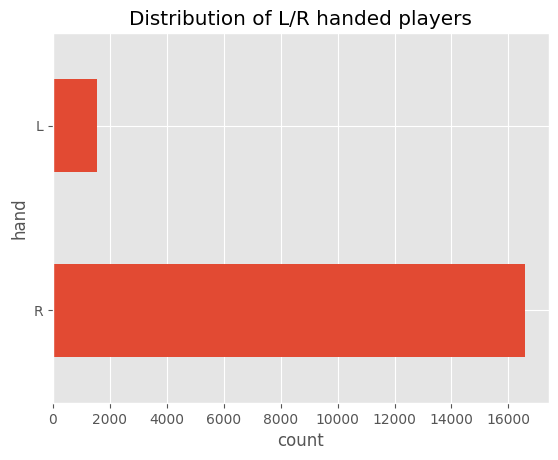

In [3]:
plt.style.use('ggplot')

hand_counts = players_table[
    players_table['hand'].isin(('L', 'R'))
]['hand'].value_counts()

hand_counts.plot(kind='barh')
plt.xlabel('count')
plt.title('Distribution of L/R handed players')
plt.show()

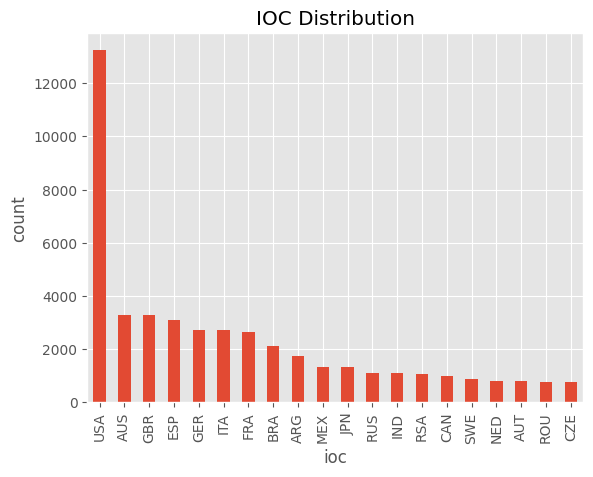

In [4]:
# Look at IOC distribution
ioc_counts = players_table['ioc'].value_counts().head(20)
ioc_counts.plot(kind='bar')
plt.title('IOC Distribution')
plt.ylabel('count')
plt.show()

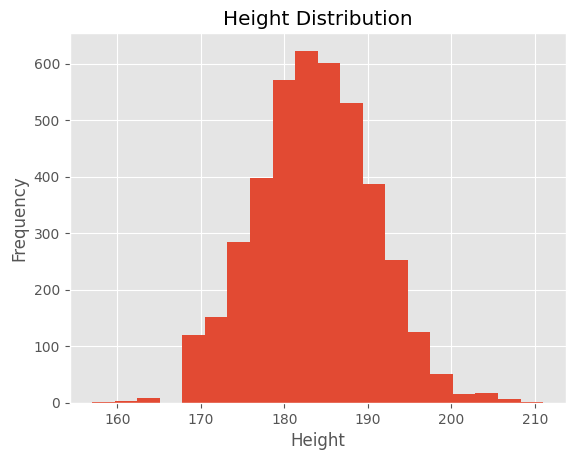

In [5]:
height_data = players_table['height']
height_data = height_data[height_data > 150].dropna()


height_data.plot(kind='hist', bins=20, range=(height_data.min(), height_data.max()))
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Distribution')
plt.show()

# Table 2: ATP Ranks
- This table has a one-to-many relationship
- There are no NaN values in this dataset.

In [6]:
ranks_table = pd.read_csv('../tennis_atp/atp_rankings_current.csv')
ranks_table

,ranking_date,rank,player,points
0,20240101,1,104925,11245
1,20240101,2,207989,8855
2,20240101,3,106421,7600
3,20240101,4,206173,6490
4,20240101,5,126094,4805
...,...,...,...,...
92336,20241230,2156,210732,1
92337,20241230,2159,210575,1
92338,20241230,2160,212194,1
92339,20241230,2160,135939,1


In [7]:
ranks_table.sort_values(by=['ranking_date', 'rank'], ascending=[False, True], inplace=True)
merged_table = ranks_table.merge(players_table, left_on='player', right_on='player_id', how='left')
merged_table.head(10)

,ranking_date,rank,player,points,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
0,20241230,1,206173,11830,206173,Jannik,Sinner,R,20010816.0,ITA,191.0,Q54812588
1,20241230,2,100644,7915,100644,Alexander,Zverev,R,19970420.0,GER,198.0,Q13990552
2,20241230,3,207989,7010,207989,Carlos,Alcaraz,R,20030505.0,ESP,183.0,Q85518537
3,20241230,4,126203,5100,126203,Taylor,Fritz,R,19971028.0,USA,196.0,Q17660516
4,20241230,5,106421,5030,106421,Daniil,Medvedev,R,19960211.0,RUS,198.0,Q21622022
5,20241230,6,134770,4255,134770,Casper,Ruud,R,19981222.0,NOR,183.0,Q18810082
6,20241230,7,104925,3910,104925,Novak,Djokovic,R,19870522.0,SRB,188.0,Q5812
7,20241230,8,126094,3760,126094,Andrey,Rublev,R,19971020.0,RUS,188.0,Q17373391
8,20241230,9,200282,3745,200282,Alex,De Minaur,R,19990217.0,AUS,183.0,Q22958938
9,20241230,10,105777,3350,105777,Grigor,Dimitrov,R,19910516.0,BUL,191.0,Q337681


# Table 3: ATP Matches
- For prediction, this will have the most impact
- Looking at performance on surfaces, against certain players, etc. will be important for tennis prediction
- Dataset is split by year - we can compound it into a new full dataset.
- We will look at past 5 years of tennis as it is the most statistically relevant

In [8]:
start_year, n_years = 2020, 5
year_tables = [pd.read_csv(f'../tennis_atp/atp_matches_{year}.csv') for year in range(start_year, start_year + n_years)]

for year, table in enumerate(year_tables, start_year):
    table.insert(0, 'year', year)

match_table = pd.concat(year_tables, ignore_index=True)
match_table.head()

,year,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2020,2020-8888,Atp Cup,Hard,24,A,20200106,300,104925,NaN,...,51.0,39.0,6.0,10.0,6.0,8.0,2.0,9055.0,1.0,9985.0
1,2020,2020-8888,Atp Cup,Hard,24,A,20200106,299,105138,NaN,...,35.0,21.0,6.0,9.0,5.0,10.0,10.0,2335.0,34.0,1251.0
2,2020,2020-8888,Atp Cup,Hard,24,A,20200106,298,104925,NaN,...,57.0,35.0,25.0,14.0,6.0,11.0,2.0,9055.0,5.0,5705.0
3,2020,2020-8888,Atp Cup,Hard,24,A,20200106,297,105583,NaN,...,54.0,39.0,14.0,12.0,0.0,1.0,34.0,1251.0,17.0,1840.0
4,2020,2020-8888,Atp Cup,Hard,24,A,20200106,296,104745,NaN,...,55.0,37.0,10.0,14.0,1.0,5.0,1.0,9985.0,18.0,1775.0


Text(0, 0.5, 'loser rank points')

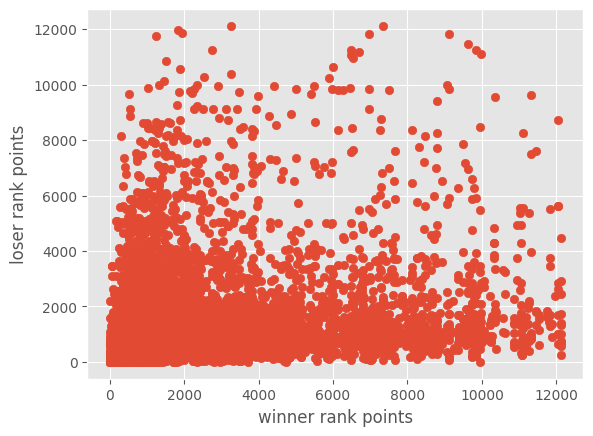

In [9]:
plt.scatter(match_table['winner_rank_points'], match_table['loser_rank_points'])
plt.xlabel('winner rank points')
plt.ylabel('loser rank points')